In [1]:
import torch
import torch.nn as nn
import h5py
import numpy as np
import torchvision.transforms.functional as TF
import torchvision
from torchvision.utils import save_image
from PIL import Image

from __init__ import *

In [2]:
def h5toNumpy(filepath):
    f = h5py.File(filepath, 'r')
    image = np.array(f['dataset'])
    energies = np.array(f['energies'])
    f.close()
    return image

toTensor = torchvision.transforms.ToTensor()

inTrainImage = h5toNumpy(parentdir + "\\" + "data\\panagia.h5").astype(np.float32)
inTrainImage = torch.from_numpy(inTrainImage)
inTrainImage = torch.reshape(inTrainImage, [21, 33, 2048])
inTrainImage = torch.swapaxes(inTrainImage,0,2);	inTrainImage = np.swapaxes(inTrainImage,1,2)
inTrainImage = torch.rot90(inTrainImage, 2, (2,1))

outTrainImage = toTensor(Image.open(parentdir + "\\" + "data\panagia.png").convert('RGB'))

inTestImage = h5toNumpy(parentdir + "\\" + "data\\jesus.h5").astype(np.float32)
inTestImage = torch.from_numpy(inTestImage)
inTestImage = torch.reshape(inTestImage, [31, 46, 2048])
inTestImage = torch.swapaxes(inTestImage,0,2);	inTestImage = np.swapaxes(inTestImage,1,2)
inTestImage = torch.rot90(inTestImage, 2, (2,1))

outTestImage = toTensor(Image.open(parentdir + "\\" + "data\jesus.png").convert('RGB'))

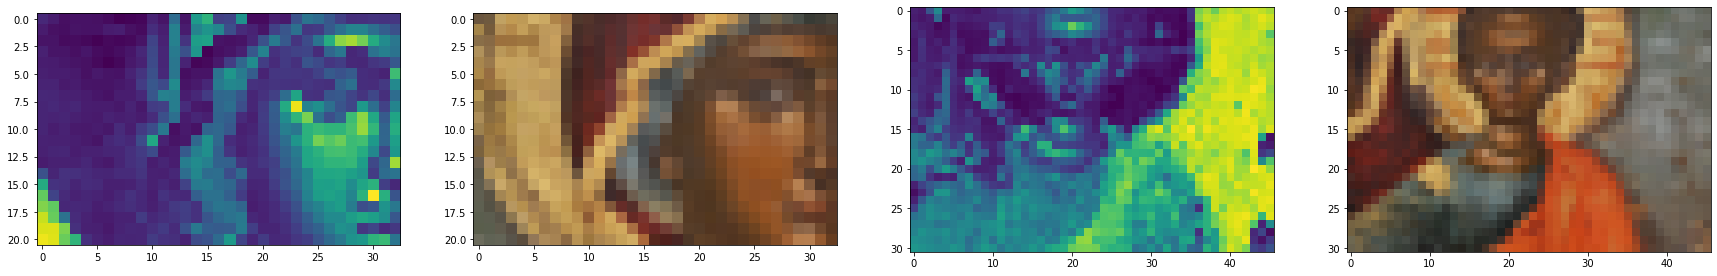

In [3]:
fix, ax = plt.subplots(nrows=1, ncols=4, figsize=(30,10))

ax[0].imshow(inTrainImage.sum(axis=0))
ax[1].imshow(outTrainImage.permute(1, 2, 0))
ax[2].imshow(inTestImage.sum(axis=0))
ax[3].imshow(outTestImage.permute(1, 2, 0))

In [4]:
class CustomDataset(Dataset):
    
    def __init__(self,inputImage,targetImage, specRange=[60,900]):
        self.specRange = specRange
        self.inputImage = inputImage
        self.targetImage = targetImage
       
        self.inputImage = torch.flatten(self.inputImage, start_dim=1, end_dim=-1)
        self.targetImage = torch.flatten(self.targetImage, start_dim=1, end_dim=-1)
                
    def __getitem__(self, index):
        return (self.inputImage[self.specRange[0]:self.specRange[1],index], self.targetImage[:,index])
    
    def __len__(self):
        return self.inputImage.shape[-1]
      

In [5]:
class CancelOut(nn.Module):
    def __init__(self,inp, *input, **kwargs):
        super(CancelOut, self).__init__()
        self.weights = nn.Parameter(torch.zeros(inp))
        
    def forward(self, x):
        return (x * torch.sigmoid(self.weights.float()))

In [6]:
class cEncoder(nn.Module):
    def __init__(self, in_channels, out_channels, cancel_out_layer):
        super(cEncoder, self).__init__()
        self.cancel_out_layer = cancel_out_layer
        self.l1 =  nn.Sequential(
            nn.Linear(in_channels, in_channels//2),
            nn.ReLU()
        )
        self.l2 =  nn.Sequential(
            nn.Linear(in_channels//2, in_channels//4),
            nn.ReLU()
        )
        self.l3 =  nn.Sequential(
            nn.Linear(in_channels//4, in_channels//8),
            nn.ReLU()
        )
        self.l4 =  nn.Sequential(
            nn.Linear(in_channels//8, in_channels//16),
            nn.ReLU()
        )
        self.l5 =  nn.Sequential(
            nn.Linear(in_channels//16, in_channels//32),
            nn.ReLU()
        )
        self.l6 =  nn.Sequential(
            nn.Linear(in_channels//32, out_channels),
        )
        self.dropout = nn.Dropout(0.0)
        # for m in self.modules():
        #     if isinstance(m, nn.Linear):
        #         m.weight.data = nn. init.xavier_uniform_(m.weight.data, gain=nn.init.calculate_gain('relu')) 
    def forward(self, x_in, train=True):
        x1 = self.cancel_out_layer(x_in)
        x1 = self.l1(x_in) #print(x1.shape)
        x2 = self.l2(x1); 
        if(train): x2 == self.dropout(x2) #print(x2.shape)
        x3 = self.l3(x2); 
        if(train): x3 == self.dropout(x3) #print(x3.shape)
        x4 = self.l4(x3)
        if(train): x4 == self.dropout(x4)
        x5 = self.l5(x4) #print(x4.shape)
        if(train): x5 == self.dropout(x5) #print(x4.shape)
        x_enc = self.l6(x5)
        return x1,x2,x3,x4,x5,x_enc

In [7]:
class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Encoder, self).__init__()
        self.l1 =  nn.Sequential(
            nn.Linear(in_channels, in_channels//2),
            nn.ReLU()
        )
        self.l2 =  nn.Sequential(
            nn.Linear(in_channels//2, in_channels//4),
            nn.ReLU()
        )
        self.l3 =  nn.Sequential(
            nn.Linear(in_channels//4, in_channels//8),
            nn.ReLU()
        )
        self.l4 =  nn.Sequential(
            nn.Linear(in_channels//8, in_channels//16),
            nn.ReLU()
        )
        self.l5 =  nn.Sequential(
            nn.Linear(in_channels//16, in_channels//32),
            nn.ReLU()
        )
        self.l6 =  nn.Sequential(
            nn.Linear(in_channels//32, out_channels),
        )
        self.dropout = nn.Dropout(0.0)
        # for m in self.modules():
        #     if isinstance(m, nn.Linear):
        #         m.weight.data = nn. init.xavier_uniform_(m.weight.data, gain=nn.init.calculate_gain('relu')) 
                
    def forward(self, x_in, train=True):
        x1 = self.l1(x_in) #print(x1.shape)
        x2 = self.l2(x1); 
        if(train): x2 == self.dropout(x2) #print(x2.shape)
        x3 = self.l3(x2); 
        if(train): x3 == self.dropout(x3) #print(x3.shape)
        x4 = self.l4(x3)
        if(train): x4 == self.dropout(x4)
        x5 = self.l5(x4) #print(x4.shape)
        if(train): x5 == self.dropout(x5) #print(x4.shape)
        x_enc = self.l6(x5)
        return x1,x2,x3,x4,x5,x_enc

In [8]:
class uDecoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(uDecoder, self).__init__()
        self.l1 =  nn.Sequential(
            nn.Linear(in_channels, out_channels//32),
            nn.ReLU()
        )
        self.l2 =  nn.Sequential(
            nn.Linear(out_channels//32, out_channels//16),
            nn.ReLU()
        )
        self.l3 =  nn.Sequential(
            nn.Linear(out_channels//16, out_channels//8),
            nn.ReLU()
        )
        self.l4 =  nn.Sequential(
            nn.Linear(out_channels//8, out_channels//4),
            nn.ReLU()
        )
        self.l5 =  nn.Sequential(
            nn.Linear(out_channels//4, out_channels//2),
            nn.ReLU()
        )
        self.l6 =  nn.Sequential(
            nn.Linear(out_channels//2, out_channels),
            nn.ReLU()
        )
        self.lfin = nn.Linear(out_channels, out_channels)
        self.dropout = nn.Dropout(0.0)
        # for m in self.modules():
        #     if isinstance(m, nn.Linear):
        #         m.weight.data = nn. init.xavier_uniform_(m.weight.data, gain=nn.init.calculate_gain('relu')) 
    def forward(self, x1_e,x2_e,x3_e,x4_e,x5_e,x_in, train=True):
        x1 = self.l1(x_in) #print(x1.shape, x5_e.shape)
        x2 = self.l2(x1 * x5_e); 
        if(train): x2 == self.dropout(x2) #print(x2.shape)    
        x3 = self.l3(x2 * x4_e); 
        if(train): x3 == self.dropout(x3) #print(x3.shape)
        x4 = self.l4(x3 * x3_e); 
        if(train): x4 == self.dropout(x4) #print(x4.shape)
        x5 = self.l5(x4 * x2_e); 
        if(train): x5 == self.dropout(x5) #print(x5.shape)
        x_6 = self.l6(x5 * x1_e) #print(x5.shape)
        x_dec = self.lfin(x_6)
        return x_dec 

In [9]:
class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Decoder, self).__init__()
        self.l1 =  nn.Sequential(
            nn.Linear(in_channels, out_channels//32),
            nn.ReLU()
        )
        self.l2 =  nn.Sequential(
            nn.Linear(out_channels//32, out_channels//16),
            nn.ReLU()
        )
        self.l3 =  nn.Sequential(
            nn.Linear(out_channels//16, out_channels//8),
            nn.ReLU()
        )
        self.l4 =  nn.Sequential(
            nn.Linear(out_channels//8, out_channels//4),
            nn.ReLU()
        )
        self.l5 =  nn.Sequential(
            nn.Linear(out_channels//4, out_channels//2),
            nn.ReLU()
        )
        self.l6 =  nn.Sequential(
            nn.Linear(out_channels//2, out_channels),
        )
        self.dropout = nn.Dropout(0.0)
        # for m in self.modules():
        #     if isinstance(m, nn.Linear):
        #         m.weight.data = nn. init.xavier_uniform_(m.weight.data, gain=nn.init.calculate_gain('relu')) 
    def forward(self, x1_e,x2_e,x3_e,x4_e,x5_e,x_in, train=True):
        x1 = self.l1(x_in) #print(x1.shape, x5_e.shape)
        x2 = self.l2(x1 + x5_e); 
        if(train): x2 == self.dropout(x2) #print(x2.shape)    
        x3 = self.l3(x2 + x4_e); 
        if(train): x3 == self.dropout(x3) #print(x3.shape)
        x4 = self.l4(x3 + x3_e); 
        if(train): x4 == self.dropout(x4) #print(x4.shape)
        x5 = self.l5(x4 + x2_e); 
        if(train): x5 == self.dropout(x5) #print(x5.shape)
        x_dec = self.l6(x5)
        return x_dec 

In [10]:
def PSNR(img1, img2):
    return 20 * torch.log10(
        1.0 / torch.sqrt(
            torch.mean((img1*1.0 - img2*1.0) ** 2)
        )
    )

In [11]:
def train(N_TRAIN = 1, N_EPOCHS = 200, L_RATE = 0.0002, TRAIN_AE = False, BATCH_SIZE = 32, OUT_FILENAME = 'encoder', 
        loss_1=None, loss_2=None, encoder=None, decoder=None, device="cuda", specRange=[60,900]):

    trainLoader = DataLoader(
        dataset=CustomDataset(inTrainImage,outTrainImage,specRange=specRange), 
        batch_size=32, shuffle=True
    )
    testLoader = DataLoader(
        dataset=CustomDataset(inTestImage,outTestImage,specRange=specRange), 
        batch_size=1, shuffle=False
    )

    if(not loss_1): loss_1 = nn.MSELoss() # for decoder
    if(not loss_2): loss_2 = nn.L1Loss() # addictional loss to encoder
        
    avg_psnr_metric = 0; total_max_psnr_metric = 0 
    best_encoder = None
    
    for i_train in range(N_TRAIN):
        
        #if(not encoder):encoder = cEncoder(specRange[1]-specRange[0],3, CancelOut(specRange[1]-specRange[0]).to(device)).to(device)
        if(not encoder):encoder = Encoder(specRange[1]-specRange[0],3).to(device)
        enc_optimizer = torch.optim.Adam(encoder.parameters(), lr=L_RATE)
        if(not decoder): decoder = Decoder(3,specRange[1]-specRange[0]).to(device)
        dec_optimizer = torch.optim.Adam(decoder.parameters(), lr=L_RATE)

        
        ##### TRAINING #####
        max_psnr_metric = -1
        for epoch in range(N_EPOCHS):

            for pixel , pixel_real in trainLoader:

                pixel, pixel_real = pixel.to(device), pixel_real.to(device)
                
                ### Decoder Loss Estimation ###
                dec_loss = 0
                if(TRAIN_AE):
                    dec_optimizer.zero_grad()
                    with torch.no_grad():
                        x1,x2,x3,x4,x5,encoded  = encoder(pixel)
                    decoded = decoder(x1,x2,x3,x4,x5,encoded.detach())
                    dec_loss += loss_1(decoded, pixel) 

                ### Encoder Loss Estimation ###
                enc_optimizer.zero_grad()
                x1,x2,x3,x4,x5,encoded  = encoder(pixel)
                enc_loss = loss_2(encoded, pixel_real) 
                
                if(TRAIN_AE): 
                    with torch.no_grad():
                        decoded = decoder(x1,x2,x3,x4,x5,encoded)
                    enc_loss += loss_1(decoded, pixel) 
                
                ### Update Models Weights ###
                enc_loss.backward()
                enc_optimizer.step()
                if(TRAIN_AE):
                    dec_loss.backward()
                    dec_optimizer.step()

            ##### VALIDATING #####
            out_img = torch.zeros(3, 31, 46)
            for i, (pixel, pixel_real) in enumerate(testLoader):
                pixel, pixel_real = pixel.to(device), pixel_real.to(device)
                r = i // 46; c = i % 46
                with torch.no_grad():
                    x1,x2,x3,x4,x5,encoded = encoder(pixel, train=False)
                out_img[:, r, c] = encoded

            ##### SHOW CURRENT RESULTS #####    
            psnr_metric = PSNR(out_img, outTestImage)
            if(psnr_metric.item() > max_psnr_metric):
                max_psnr_metric = psnr_metric.item()
            if(psnr_metric.item() > total_max_psnr_metric):
                best_encoder = encoder
                total_max_psnr_metric = psnr_metric.item()
                save_image(out_img, './results/spec2spec/currbest_'+
                    OUT_FILENAME+'-'
                    'bs_'+str(BATCH_SIZE)+'-'+
                    'lr_'+str(L_RATE)+'-'+
                    '.png')
            
                
                

            print(" | i_train "+str(i_train)+ 
                " | epoch "+str(epoch)+
                " | enc_loss "+str(round(enc_loss.item(),6))+
                " | psnr "+str(round(max_psnr_metric,2)), end="\r")
        
        print()
        avg_psnr_metric += max_psnr_metric / N_TRAIN
        
    print(" === AVERAGE_PSNR:"+str(round(avg_psnr_metric,2))+" ===")
  
    return best_encoder, avg_psnr_metric

In [12]:
def test(encoder, OUT_FILENAME = 'encoder', device="cuda", specRange=[60,900]):
    testLoader = DataLoader(
        dataset=CustomDataset(inTestImage,outTestImage,specRange=specRange), 
        batch_size=1, shuffle=False
    )
    out_img = torch.zeros(3, 31, 46)
    for i, (pixel, pixel_real) in enumerate(testLoader):
        pixel, pixel_real = pixel.to(device), pixel_real.to(device)
        r = i // 46; c = i % 46
        with torch.no_grad():
            _,_,_,_,_,encoded = encoder(pixel, train=False)
        out_img[:, r, c] = encoded

    ##### SHOW CURRENT RESULTS #####    
    return out_img, PSNR(out_img, outTestImage)

In [13]:
simple_encoder_840_to_3, simple_encoder_840_to_3_PSNR = train(
    N_TRAIN=1, TRAIN_AE=False, OUT_FILENAME='simple_encoder_840_to_3', loss_1=nn.MSELoss(), loss_2=nn.L1Loss(), specRange=[60,900]
)

simple_autoencoder_840_to_840, simple_autoencoder_840_to_840_PSNR = train(
    N_TRAIN=1, TRAIN_AE=True, OUT_FILENAME='simple_autoencoder_840_to_840', loss_1=nn.MSELoss(), loss_2=nn.L1Loss(), specRange=[60,900]
)

cancelout_autoencoder_840_to_840, cancelout_autoencoder_840_to_840_PSNR = train(
    N_TRAIN=1, TRAIN_AE=True, OUT_FILENAME='cancelout_autoencoder_840_to_840', loss_1=nn.MSELoss(), loss_2=nn.L1Loss(), specRange=[60,900],
    encoder=cEncoder(840,3, CancelOut(840).to(device='cuda')).to(device='cuda')
)

In [ ]:
simple_encoder_2048_to_3, simple_encoder_2048_to_3_PSNR = train(
    N_TRAIN=1, TRAIN_AE=False, OUT_FILENAME='simple_encoder_2048_to_3', loss_1=nn.MSELoss(), loss_2=nn.L1Loss(), specRange=[0,2048]
)

simple_autoencoder_2048_to_2048, simple_autoencoder_2048_to_2048_PSNR = train(
    N_TRAIN=1, TRAIN_AE=True, OUT_FILENAME='simple_autoencoder_2048_to_2048', loss_1=nn.MSELoss(), loss_2=nn.L1Loss(), specRange=[0,2048]
)

cancelout_autoencoder_2048_to_2048, cancelout_autoencoder_2048_to_2048_PSNR = train(
    N_TRAIN=1, TRAIN_AE=True, OUT_FILENAME='cancelout_autoencoder_2048_to_2048', loss_1=nn.MSELoss(), loss_2=nn.L1Loss(), specRange=[0,2048],
    encoder=cEncoder(2048,3, CancelOut(2048).to(device='cuda')).to(device='cuda')
)

In [ ]:
unet_autoencoder_2048_to_2048, unet_autoencoder_2048_to_2048_PSNR = train(
    N_TRAIN=1, TRAIN_AE=True, OUT_FILENAME='unet_autoencoder_2048_to_2048', loss_1=nn.MSELoss(), loss_2=nn.L1Loss(), specRange=[0,2048],
    decoder=uDecoder(3,2048).to(device='cuda')
)

cancelout_unet_autoencoder_2048_to_2048, cancelout_unet_autoencoder_2048_to_2048_PSNR = train(
    N_TRAIN=1, TRAIN_AE=True, OUT_FILENAME='cancelout_unet_autoencoder_2048_to_2048', loss_1=nn.MSELoss(), loss_2=nn.L1Loss(), specRange=[0,2048],
    decoder=uDecoder(3,2048).to(device='cuda'), encoder=cEncoder(2048,3, CancelOut(2048).to(device='cuda')).to(device='cuda')
)

In [ ]:
fix, ax = plt.subplots(nrows=3, ncols=3, figsize=(30,10))

simple_encoder_840_to_3_img, simple_encoder_840_to_3_PSNR = test(simple_encoder_840_to_3)
ax[0,0].imshow(simple_encoder_840_to_3_img.permute(1, 2, 0))
ax[0,0].set_xlabel('simple_encoder_840_to_3 '+str(simple_encoder_840_to_3_PSNR))
simple_autoencoder_840_to_840_img, simple_autoencoder_840_to_840_PSNR = test(simple_autoencoder_840_to_840)
ax[0,1].imshow(simple_autoencoder_840_to_840_img.permute(1, 2, 0))
ax[0,1].set_xlabel('simple_autoencoder_840_to_840 '+str(simple_autoencoder_840_to_840_PSNR))
cancelout_autoencoder_840_to_840_img, cancelout_autoencoder_840_to_840_PSNR = test(cancelout_autoencoder_840_to_840)
ax[0,2].imshow(cancelout_autoencoder_840_to_840_img.permute(1, 2, 0))
ax[0,2].set_xlabel('cancelout_autoencoder_840_to_840 '+str(cancelout_autoencoder_840_to_840_PSNR))
simple_encoder_2048_to_3_img, simple_encoder_2048_to_3_PSNR = test(simple_encoder_2048_to_3, specRange=[0,2048])
ax[1,0].imshow(simple_encoder_2048_to_3_img.permute(1, 2, 0))
ax[1,0].set_xlabel('simple_encoder_2048_to_3 '+str(simple_encoder_2048_to_3_PSNR))
simple_autoencoder_2048_to_2048_img, simple_autoencoder_2048_to_2048_PSNR = test(simple_autoencoder_2048_to_2048, specRange=[0,2048])
ax[1,1].imshow(simple_autoencoder_2048_to_2048_img.permute(1, 2, 0))
ax[1,1].set_xlabel('simple_autoencoder_2048_to_2048 '+str(simple_autoencoder_2048_to_2048_PSNR))
cancelout_autoencoder_2048_to_2048_img, cancelout_autoencoder_2048_to_2048_PSNR = test(cancelout_autoencoder_2048_to_2048, specRange=[0,2048])
ax[1,2].imshow(cancelout_autoencoder_2048_to_2048_img.permute(1, 2, 0))
ax[1,2].set_xlabel('cancelout_autoencoder_2048_to_2048 '+str(cancelout_autoencoder_2048_to_2048_PSNR))
unet_autoencoder_2048_to_2048_img, unet_autoencoder_2048_to_2048_PSNR = test(unet_autoencoder_2048_to_2048, specRange=[0,2048])
ax[2,0].imshow(unet_autoencoder_2048_to_2048_img.permute(1, 2, 0))
ax[2,0].set_xlabel('unet_autoencoder_2048_to_2048 '+str(unet_autoencoder_2048_to_2048_PSNR))
cancelout_unet_autoencoder_2048_to_2048_img, cancelout_unet_autoencoder_2048_to_2048_PSNR = test(cancelout_unet_autoencoder_2048_to_2048, specRange=[0,2048])
ax[2,1].imshow(cancelout_unet_autoencoder_2048_to_2048_img.permute(1, 2, 0))
ax[2,1].set_xlabel('cancelout_unet_autoencoder_2048_to_2048 '+str(cancelout_unet_autoencoder_2048_to_2048_PSNR))
ax[2,2].imshow(outTestImage.permute(1, 2, 0))
ax[2,2].set_xlabel('Ground Truth')